# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
from mls import nn_unit_draw2d, nn_graph_draw2d, locate_data

## Neural Networks

From a user's perspective, a neural network (NN) is a class of models $Y = N(X; \Theta)$ that are:
 - Generic: they are not tailored to any particular application.
 - Flexible: they can accurately represent a wide range of non-linear $X\rightarrow Y$ mappings with a suitable choice of parameters $\Theta$.
 - Trainable: a robust optimization algorithm (backpropagation) can learn parameters $\Theta$ given enough training data $D = (X,Y)$.
 - Modular: it is straightforward to scale the model complexity (and number of parameters) to match the available training data.
 - Efficient: most of the internal computations are linear and amenable to parallel computation and hardware acceleration.

The "neural" aspect of a neural network is tenuous. Their design mimics some aspects of biological neurons, but also differs in fundamental ways.

The internal structure of a NN is naturally described by a computation graph that connects simple building blocks. The basic building-block unit is a function of $D$ input features $x_i$,
$$
f(\mathbf{x}) = \phi\left(\mathbf{w}\cdot\mathbf{x} + b\right)
$$
with $D+1$ parameters consisting of **weights** $w_i$ and a **bias** $b$. Note that this building block is mostly linear, except for the **activation function** $\phi(s)$. This is another application of the kernel trick that we met [earlier](Nonlinear.ipynb), and allows us to implicitly work in a higher dimensional space where non-linear structure of the training data is easier to model.

The building-block unit is straightfoward to implement:

In [4]:
def nn_unit(x, w, b, phi):
    return phi(np.dot(w, x) + b)

For example, with a 3D $\mathbf{x}$, the weight vector $w$ should also be 3D:

In [5]:
x = [1, 0, -1]
nn_unit(x, w=[1, 2, 3], b=-1, phi=np.tanh)

-0.99505475368673046

### Activation Functions

The activation function $\phi$ argument $s$ is always a scalar and, by convention, activation functions are always defined in a standard form, without any parameters, since $\mathbf{w}$ and $b$ already provide enough flexibility for scaling and applying an offset.

Some common activations are defined below (using [lambda functions](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions)):

In [6]:
linear = lambda s: s
relu = lambda s: np.maximum(0, s)
elu = lambda s: s * (s >= 0) + np.expm1(s) * (s < 0) # expm1(s) = exp(s) - 1
softplus = lambda s: np.log(1 + np.exp(s))
sigmoid = lambda s: 1 / (1 + np.exp(-s)) # also known as the "logistic function"
tanh = lambda s: np.tanh(s)
softsign = lambda s: s / (np.abs(s) + 1)

These activations divide naturally into to two categories depending on their asymptotic behavior as $s\rightarrow +\infty$:

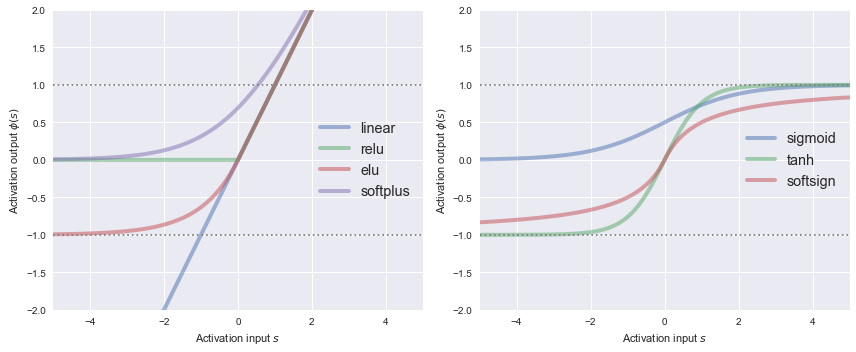

In [7]:
def plot_activations(ax, names, s_range=5, y_range=2):
    s = np.linspace(-s_range, +s_range, 101)
    for name in names.split(','):
        phi = eval(name)
        ax.plot(s, phi(s), lw=4, alpha=0.5, label=name)
    ax.legend(fontsize='x-large')
    ax.set_xlabel('Activation input $s$')
    ax.set_ylabel('Activation output $\phi(s)$')
    ax.set_xlim(-s_range, +s_range)
    ax.set_ylim(-y_range, +y_range)
    ax.axhline(-1, c='gray', ls=':')
    ax.axhline(+1, c='gray', ls=':')
    
_, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_activations(ax[0], 'linear,relu,elu,softplus')
plot_activations(ax[1], 'sigmoid,tanh,softsign')
plt.tight_layout()

**EXERCISE:** For each activation function plotted above:
 - Which activations are asymptotically linear as $s\rightarrow \pm\infty$?
 - Which activations are asymptotically constant as $s\rightarrow \pm\infty$?
 - Which activations are differentiable at $s=0$?
 - Which activations are better suited for classification or regression problems?

The table below summarizes the properties of each activation function:

| Activation  | Limit as $s\rightarrow-\infty$ | Limit as $s\rightarrow+\infty$ | Differentiable at $s=0$? |
|-------------|------|------|
| identity    | linear | linear | Y |
| relu        | 0      | linear | N |
| elu         | -1     | linear | Y |
| softplus    | 0      | linear | Y |
| sigmoid     | 0      | +1     | Y |
| tanh        | -1     | +1     | Y |
| softsign    | -1     | +1     | Y |

The activations that are bounded on both sides only have a narrow range near $s=0$ where they distinguish between different input values, and otherwise are essentially saturated.  This is desirable for classification, where the aim is to place $s=0$ close to the "decision boundary".

For a regression problem, the saturation property is undesirable since it limits the range over which a desired continuous transformation can be fit.  Therefore the activations that are linear as $s\rightarrow +\infty$ are best suited to regression.

---

![Activation maps](img/NeuralNetworks/activation_maps.png)

**EXERCISE:** Identify which activation function was used to make each plot above, which shows $f(\mathbf{x})$ for a 2D $\mathbf{x}$ with the same $\mathbf{w}$ and $b$. Red and blue indicate positive and negative values, respectively, with zero displayed as white.

- (a) linear
- (b) tanh
- (c) relu
- (d) softsign
- (e) sigmoid
- (f) elu

To distinguish between (b) and (d), note that both go asymptotically to constant negative and positive values (so sigmoid is ruled out), but the white transition region is narrower for (d).

To distinguish between (c) and (f), note that (c) goes asymptotically to zero (white) in the top-left corner, while (e) goes asymptotically to a constant negative value (blue).

---

**EXERCISE:** Experiment with the following function to determine how the displayed arrow relates to the three model parameters $w_0, w_1, b$:
```
nn_unit_draw2d(w=[0, 2], b=-1, phi=tanh)
```

The arrow has the direction and magnitude of the 2D vector $\mathbf{w}$, with its origin at $\mathbf{x} = -b \mathbf{w}\, / \, |\mathbf{w}|^2$ where $s = 0$. The line $s=0$ is perpendicular to the arrow.

In [193]:
# Work on your solution here...

### Network Layers

We can build a multi-output **layer** function of $\mathbf{x}$ by stacking our basic unit vertically,
$$
\mathbf{f}(\mathbf{x}) = \begin{bmatrix}
f_1(\mathbf{x}) \\
f_2(\mathbf{x}) \\
\vdots
\end{bmatrix} \; ,
$$
with
$$
f_k(\mathbf{x}) = \phi\left( \mathbf{w}_k\cdot \mathbf{x} + b_k \right) \; .
$$
Note that the outputs share the same activation $\phi(s)$ but each have their own parameters $\mathbf{w}_k$ and $b_k$. If we stack the parameters into a matrix,
$$
W = \begin{bmatrix}
\mathbf{w}_1 \\
\mathbf{w}_2 \\
\vdots
\end{bmatrix} \; ,
$$
and vector
$$
\mathbf{b} = \begin{bmatrix}
b_1 \\
b_2 \\
\vdots
\end{bmatrix} \; ,
$$
then the resulting layer function is simply
$$
\mathbf{f}(\mathbf{x}) = W\mathbf{x} + \mathbf{b} \; .
$$
Note that we are using boldface to indicate vectors, but the dimension $n_{out}$ of $\mathbf{f}$ and $\mathbf{b}$ is generally different than the dimension $n_{in}$ of $\mathbf{x}$. The matrix $W$ with dimensions $n_{out} \times n_{in}$ transforms between the input and output dimensions.

The `nn_unit` function we defined above already implements a layer if we pass it a matrix $W$ and vector $\mathbf{b}$. For example:

In [8]:
nn_unit(x=[-1, 1], w=[[1, 2], [-1, 0], [1, -1]], b=[-1, 1, 0], phi=linear)

array([ 0,  2, -2])

**EXERCISE:** What is $n_{in}$ and $n_{out}$ for the example above?

The number of inputs equals the number of elements in $\mathbf{x}$ and the number of columns in $W$, i.e., $n_{in} = 2$.

The number of outputs equals the number of rows in $W$ and the number of elements in $\mathbf{b}$, i.e., $n_{out} = 3$.

---

**EXERCISE:** How many parameters does a layer specified by $(n_{in}, n_{out})$ have?

The matrix $W$ has $n_{in}\times n_{out}$ parameters and the offset $\mathbf{b}$ adds another $n_{out}$ parameters, for a total of:
$$
n_{param} = (n_{in} + 1)\, n_{out} \; .
$$

---

Finally, we can build a simple **feedfoward graph** by stacking layers horizontally, which corresponds to nested calls of each layer's function:
$$
N(\mathbf{x}) = \mathbf{h}\left(\mathbf{g}\left(\ldots \mathbf{f}(\mathbf{x})\right)\right)
$$

In [9]:
def nn_graph(x, *layers):
    for W, b, phi in layers:
        x = nn_unit(x, W, b, phi)
    return x

For example, here is a three-layer network. Note how the output dimension of one layer must match the input dimension of the next layer. Layers between the input and output layers are known as **hidden layers**.

In [10]:
nn_graph([-1, 1],
    ([[2,-0.5],[0,-2]], [0, 0], tanh),           # LYR1: n_in=2, n_out=2
    ([[+1,-1],[-1,+1],[0,1]], [-1,0,1], relu),   # LYR2: n_in=2, n_out=3
    ([[1,2,3]], [0], linear)                     # LYR3: n_in=3, n_out=1
)

array([ 0.1530907])

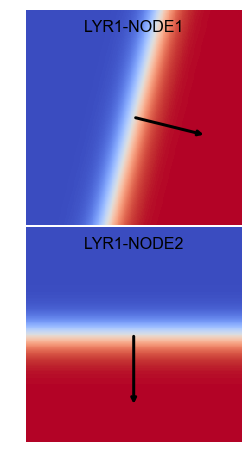

In [11]:
nn_graph_draw2d(
    ([[2,-0.5],[0,-2]], [0, 0], tanh), # LYR1
)

**EXERCISE:** The diagram above shows the outputs $(y_1, y_2)$ from a layer with $n_{in} = n_{out} = 2$ as a function of its inputs $(x_1, x_2)$.
 - Describe how the outputs cluster in 2D assuming that the inputs are uniformly distributed.
 - Suppose we add a second layer with $n_{in} = 2$ and a single $z$ output, $n_{out} = 1$, using `tanh` activation again. What $W$ and $\mathbf{b}$ would "select" ($z \simeq +1$) the upper right corner while "rejecting" ($z \simeq -1$) the other three corners?

Except for narrow transition regions (white), both outputs saturate at $\pm 1$. If we overlay the two two plots, there are four quandrants in $(x_1, x_2)$ to consider, which each saturate to a single point in the $(y_1, y_2)$ plane:
 - upper right corner: $(y_1, y_2) \simeq (+1, -1)$.
 - lower right corner: $(y_1, y_2) \simeq (+1, +1)$.
 - lower left corner: $(y_1, y_2) \simeq (-1, +1)$.
 - upper left corner: $(y_1, y_2) \simeq (-1, -1)$.

Therefore the outputs cluster around these four points in the $(y_1, y_2)$ plane. To show this explicitly, generate some random $(x_1, x_2)$ points and plot their corresponding $(y_1, y_2)$ values:

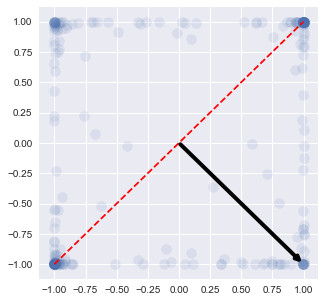

In [12]:
gen = np.random.RandomState(seed=123)
X = gen.uniform(-3, +3, (250, 2))
LYR1 = ([[2,-0.5],[0,-2]], [0, 0], tanh)
Y = np.array([nn_graph(x, LYR1) for x in X])

fig = plt.figure(figsize=(5, 5))
plt.scatter(Y[:, 0], Y[:, 1], s=100, alpha=0.1)
plt.plot([-1, 1], [-1, 1], 'r--')
plt.annotate('', xy=[1,-1], xytext=[0,0], arrowprops=dict(arrowstyle='->', lw=4));

To select only the upper right corner with a second single-output layer, we need $W$ to point towards $(y_1, y_2) = (+1, -1)$, for example:
$$
W = \begin{bmatrix} +1\\ -1\end{bmatrix} \; .
$$
If we use $\mathbf{b} = [0]$, this would give $s \simeq 0$ (and therefore $z \simeq 0$) for both $(y_1, y_2) \simeq (+1, -1)$ and $(y_1, y_2) \simeq (-1, -1)$, instead of the desired $z \simeq -1$. However, adjusting $b$ slightly offsets $\phi(s)$ and gives the desired result:

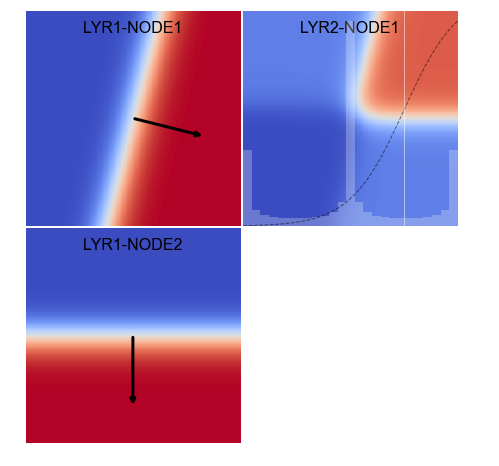

In [13]:
nn_graph_draw2d(
    ([[2,-0.5],[0,-2]], [0, 0], tanh), # LYR1
    ([[+1,-1]], [-1], tanh)            # LYR2
)

The histogram on the second layer shows the distribution of
$$
s = W \mathbf{y} + \mathbf{b}
$$
feeding its activation function (shown as the dashed curve). Note how the central histogram peak is higher because both the lower-right and upper-left quadrants of $(x_1, x_2)$ have $W \mathbf{y} \simeq 0$. The vertical line shows how our choice of $\mathbf{b}$ places these quadrants in the "rejected" category, with $s < 0$ and therefore $z \simeq -1$.

---

**EXERCISE:** Design a two-layer neural network with two inputs $(x_1, x_2)$ and a single output $z$ such that $z \simeq 1$ for a square region surrounding the origin and $z\simeq 0$ outside this square.

We will need four features $(y_1, y_2, y_3, y_4)$ in the hidden layer in order to define the edges of the square region.

The output layer will need a sigmoid activation, but the hidden layer could use any of the bounded activations.

Note that increasing $W$ and $\mathbf{b}$ by the same factor sharpens the activation's transition without changing its location.

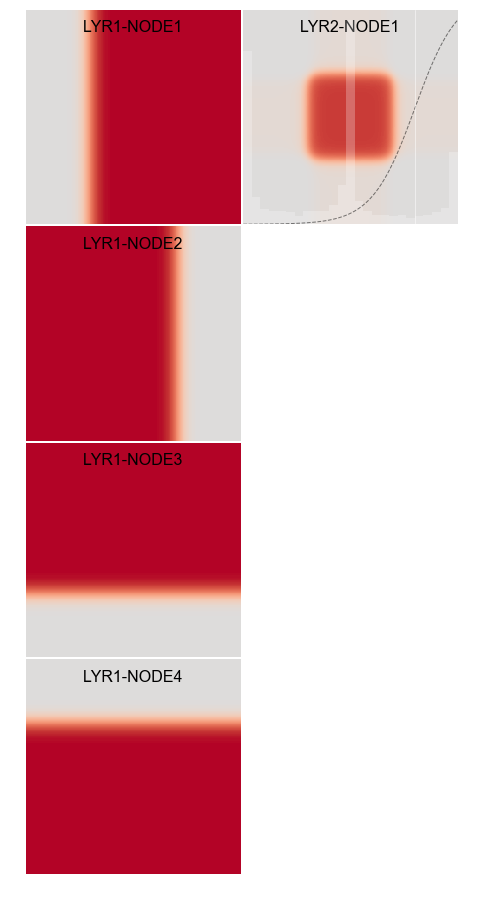

In [618]:
nn_graph_draw2d(
    ([[8,0],[-8,0],[0,8],[0,-8]], [10,10,10,10], sigmoid), # LYR1
    ([[5,5,5,5]], [-18], sigmoid)                    # LYR2
)

In [ ]:
# Add your solution here...

### Optimization

In the last exercise, you created a classifier to identify points $(x_1, x_2)$ within a box by adjusting the network's parameters by hand. However, this is obviously not practical for more complex problems. To automate this procedure, we need two new ingredients:
 - Training data $D = (X, Y)$ for supervised learning of the network parameters.
 - A **loss function** that we can optimize over the parameter space.
 
For our data, we will re-use the `circles` example from [earlier](Nonlinear.ipynb):

In [14]:
X = pd.read_hdf(locate_data('circles_data.hf5')).values
Y = pd.read_hdf(locate_data('circles_targets.hf5')).values

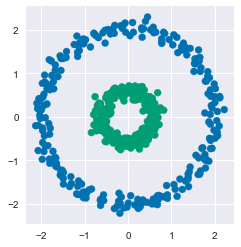

In [15]:
def plot_circles():
    cmap = sns.color_palette('colorblind', 2)
    c = [cmap[int(y)] for y in Y]
    plt.scatter(X[:, 0], X[:, 1], c=c)
    plt.gca().set_aspect(1)
    
plot_circles()

We have already seen that a network with a single four-node hidden layer is sufficient to solve this problem. To build this architecture in a tensorflow graph, use:

In [16]:
graph = tf.Graph()
with graph.as_default():
    # Feed the input layer from an external dataset.
    x_in = tf.placeholder(tf.float32, [None, 2])
    # Define the hidden layer.
    W_hidden = tf.Variable([[8.,0.],[-8.,0.],[0.,8.],[0.,-8.]])
    b_hidden = tf.Variable([10.,10.,10.,10.])
    hidden = tf.sigmoid(tf.transpose(tf.matmul(W_hidden, x_in, transpose_b=True)) + b_hidden)
    # Define the output layer.
    W_out = tf.Variable([[5.,5.,5.,5.]])
    b_out = tf.Variable([-18.])
    out = tf.sigmoid(tf.transpose(tf.matmul(W_out, hidden, transpose_b=True)) + b_out)
    # Initialize all parameters.
    initialize = tf.global_variables_initializer()

To run all samples in $X$ through this network, evaluate `out` in a session using this graph:

In [17]:
with tf.Session(graph=graph) as session:
    session.run(initialize)
    Y_fit = session.run(out, feed_dict={x_in: X})

Since we initialized the network parameters based on the example above, it already does a perfect job of classifying the training data:

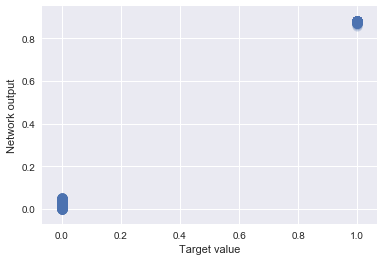

In [18]:
plt.scatter(Y, Y_fit, s=100, marker='o', alpha=0.2);
plt.xlabel('Target value')
plt.ylabel('Network output');

In order discover a good set of parameters using optimization, we need to specify a loss function to minimize. Our choice of goal function will depend on whether we are solving a regression or classification problem. For regression, the L2 norm is a good choice,
$$
L2 \equiv \frac{1}{2}\, \sum_{i=1}^N\, \left(y^\text{out}_i - y^\text{train}_i\right)^2 \; ,
$$
where the factor of $1/2$ gives this the same normalization as the negative-log-likelihood for a Gaussian.

For binary classification problems, the L2 norm can also be used but the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) between the target and output probability distributions is often a better choice.

To optimize our test problem above, we first need to start from random parameters (rather than a known good solution). Note that tensorflow wants all arrays to be 32-bit floats, not the numpy and python default 64-bit floats.

In [19]:
gen = np.random.RandomState(seed=123)
W_hidden_init = gen.normal(size=(4, 2)).astype(np.float32)
b_hidden_init = gen.normal(size=(4,)).astype(np.float32)
W_out_init = gen.normal(size=(1, 4)).astype(np.float32)
b_out_init = gen.normal(size=(1,)).astype(np.float32)

Create a graph using these random initial parameter values. We also need to:
 - Define a placeholder to read in the target $y$ values.
 - Define the loss function to minimize, which is L2 in this example.
 - Prepare an optimization algorithm to run, which is the `AdamOptimizer` in this example.

In [20]:
with graph.as_default():
    # Feed the input layer from an external dataset.
    x_in = tf.placeholder(tf.float32, [None, 2])
    # Define the hidden layer using random parameters.
    W_hidden = tf.Variable(W_hidden_init)
    b_hidden = tf.Variable(b_hidden_init)
    hidden = tf.sigmoid(tf.transpose(tf.matmul(W_hidden, x_in, transpose_b=True)) + b_hidden)
    # Define the output layer.
    W_out = tf.Variable(W_out_init)
    b_out = tf.Variable(b_out_init)
    out = tf.sigmoid(tf.transpose(tf.matmul(W_out, hidden, transpose_b=True)) + b_out)
    # Feed the target outputs from an external dataset.
    y_in = tf.placeholder(tf.float32, [None, 1])
    # Calculate the L2 loss between y_in and out.
    loss = tf.nn.l2_loss(out - y_in)
    # Prepare an optimizer to minimize the loss.
    optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
    step = optimizer.minimize(loss)
    # Initialize all parameters.
    initialize = tf.global_variables_initializer()

In our session, we run 100 steps of the optimizer and then evaluate the outputs after training. Note that we need to feed values of `y_in` to evaluate the loss but not to evaluate the trained network's outputs.

In [22]:
with tf.Session(graph=graph) as session:
    session.run(initialize)
    L2 = []
    for i in range(100):
        session.run(step, feed_dict={x_in: X, y_in: Y})
        L2.append(session.run(loss, feed_dict={x_in: X, y_in: Y}))
    Y_fit = session.run(out, feed_dict={x_in: X})

The loss function has decreased nicely and appears to be reasonably converged after 100 steps:

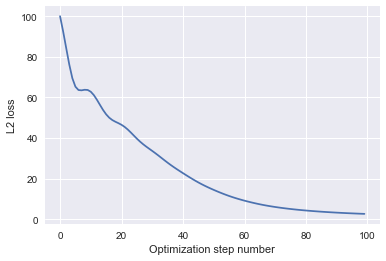

In [23]:
plt.plot(L2)
plt.xlabel('Optimization step number')
plt.ylabel('L2 loss');

The trained network does a good job of matching the targets:

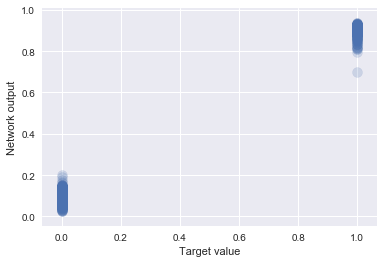

In [24]:
plt.scatter(Y, Y_fit, s=100, marker='o', alpha=0.2);
plt.xlabel('Target value')
plt.ylabel('Network output');

Note that our training found a different solution than our by-hand optimization above. This is typical when training neural networks, since their loss functions are generally not convex and have a large number of local optima.

**EXERCISE:** Experiment with this [interactive 1D regression neural network](https://cs.stanford.edu/people/karpathy/convnetjs/demo/regression.html).
 - Inspect the code in the upper box and describe the network architecture. (Hint `fc` stands for "fully connected").
 - Explain why the prediction is asymptotically flat as $x\rightarrow \pm \infty$.
 - Predict what would happen if you changed the activation function of the second layer from `sigmoid` to `relu`, then try it and see.

The network has four layers:
 - LYR1: n_in = 1, n_out = 20, activation=relu
 - LYR2: n_in = 20, n_out= 20, activation=sigmoid
 - LYR3: n_in = 20, n_out = 1, activation=linear

The prediction is asymptotically flat as $x\rightarrow \pm \infty$ because of the sigmoid activation in the second layer. Changing this activation to relu should give linear asymptotic behavior.

---